## Import Libraries

In [591]:
import torch
import requests
from torch import nn
import zipfile
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision import transforms
from torchvision import datasets
from tqdm.auto import tqdm
from helper_fuctions import accuracy_fn, eval_model, pred_and_plot_image, plot_loss_curves
import torch.nn.functional as F
import torchvision


In [592]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Importing Dataset

In [593]:
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} already exist, skipping download.')
else:
    print(f"{image_path} doesn't exists, downloading...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print("Downloading request...")
    f.write(request.content)
    
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as  z:
    print("Unzipping dataset...")
    z.extractall(image_path)

data\pizza_steak_sushi already exist, skipping download.
Unzipping dataset...


In [594]:
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

In [595]:
image = Image.open(random_image_path)

print(f'Shape: ({image.height}, {image.width}) | Label: {image_class}')
image.size

Shape: (512, 512) | Label: sushi


(512, 512)

In [596]:
img_array = np.asarray(image)
img_array.shape

(512, 512, 3)

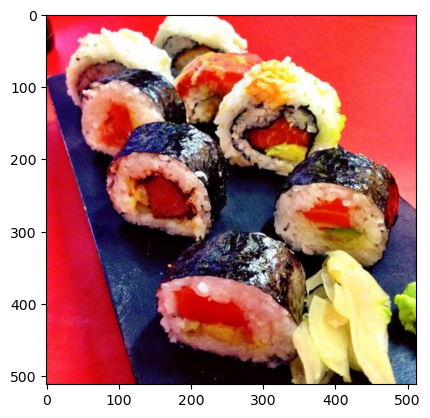

In [597]:
plt.imshow(img_array)
plt.show()

## Side by Side Comparison (Tensors-Transform and Numpy)

In [598]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
])

In [599]:
img_tensor = data_transforms(image).permute(1, 2, 0)

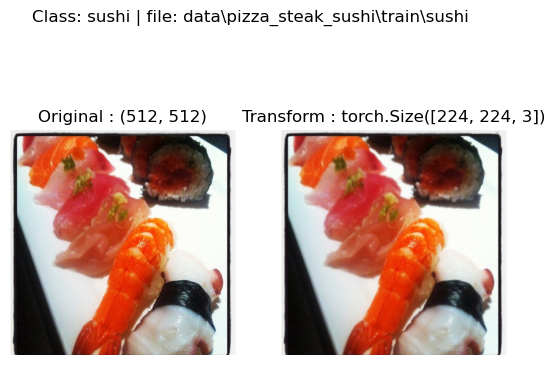

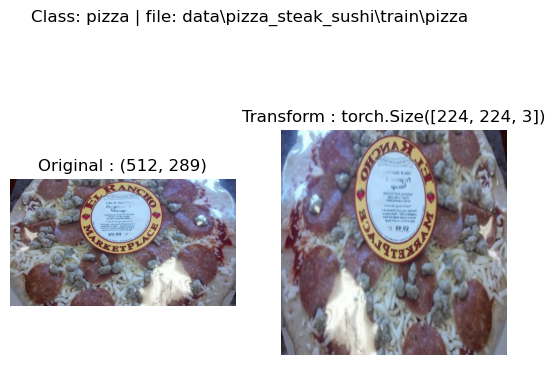

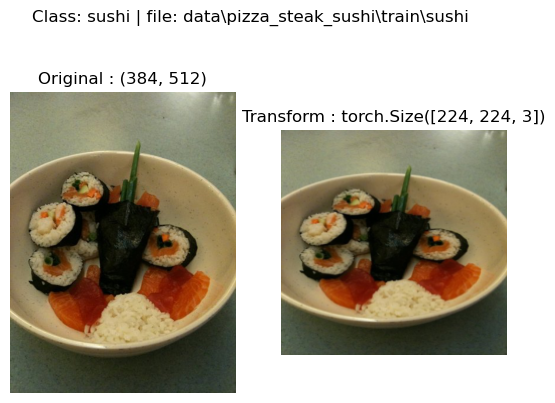

In [600]:
def plot_image(image_path, transforms, n=3, seed=None):
    if seed:
        random.seed(seed)
        random_image_path = random.sample(image_path, k=n)
        for image_path in random_image_path:
            with Image.open(image_path) as f:
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(f)
                ax[0].set_title(f"Original : {f.size}")
                ax[0].axis(False)

                transform_img = transforms(f).permute(1, 2, 0)
                ax[1].imshow(transform_img)
                ax[1].set_title(f"Transform : {transform_img.shape}")
                ax[1].axis(False)

                plt.suptitle(f"Class: {image_path.parent.stem} | file: {image_path.parent}")

plot_image(image_path=image_path_list, transforms=data_transforms, seed=12)

In [601]:
img_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        
    ])


In [602]:
train_dir = Path('data/pizza_steak_sushi') / "train"
test_dir = Path('data/pizza_steak_sushi') / "test"
train_data = datasets.ImageFolder(train_dir, img_transform)
test_data = datasets.ImageFolder(test_dir, img_transform)

In [603]:
train_dataloader = DataLoader(train_data, 32)
test_dataloader = DataLoader(test_data, 32)
train_batch = next(iter(train_dataloader))

train_batch[0].shape

torch.Size([32, 3, 64, 64])

In [604]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

## Create a Model

In [605]:
class FoodModelv0(nn.Module):
    def __init__(self, input, output):
        super().__init__()
      
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 60x60 -> 30x30
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 30x30 -> 15x15
        )

        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.Linear(1024, output),
        )
        
        
        # Fully connected layers
        

    def forward(self, x):
        x = self.conv_block1(x)
        # print(x.shape)
        x = self.conv_block2(x)
        # print(x.shape)
        x = self.conv_block3(x)
        # print(x.shape)
        x = self.conv_block4(x)
        # print(x.shape)
        x = self.linear_layer(x)
        # print(x.shape)
        
        return x

In [606]:
model = FoodModelv0(3, len(class_names)).to(device)
model.state_dict()

OrderedDict([('conv_block1.0.weight',
              tensor([[[[ 1.5215e-01, -1.3558e-01,  1.1597e-02],
                        [ 1.3812e-01, -5.1757e-02,  6.2912e-02],
                        [-1.0922e-01,  1.3882e-02, -3.0014e-02]],
              
                       [[ 1.2637e-01,  1.4395e-01, -1.8015e-01],
                        [ 1.3600e-01, -1.2336e-01, -1.1065e-01],
                        [ 1.4366e-01,  2.7618e-03, -1.3855e-01]],
              
                       [[-1.5710e-02, -1.2875e-01, -1.3013e-01],
                        [-3.4475e-02, -5.4251e-02,  6.0410e-02],
                        [ 1.4180e-01, -5.2389e-02, -1.1448e-01]]],
              
              
                      [[[ 1.8826e-01, -1.1369e-01,  1.1263e-01],
                        [ 4.1528e-02,  1.3554e-01,  5.5568e-02],
                        [-9.6067e-03, -1.4776e-01,  1.7021e-01]],
              
                       [[-1.4919e-01,  6.4749e-02,  9.7163e-02],
                        [ 7.9297e-02,

In [607]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)

## Train Model

In [608]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [609]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [610]:
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optim,
                        loss_fn=loss_fn, 
                        epochs=35)

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3932 | train_acc: 0.2930 | test_loss: 1.1315 | test_acc: 0.2083
Epoch: 2 | train_loss: 1.1091 | train_acc: 0.2930 | test_loss: 1.0984 | test_acc: 0.2083
Epoch: 3 | train_loss: 1.1065 | train_acc: 0.4023 | test_loss: 1.0918 | test_acc: 0.5000
Epoch: 4 | train_loss: 1.0959 | train_acc: 0.4023 | test_loss: 1.0870 | test_acc: 0.5000
Epoch: 5 | train_loss: 1.0965 | train_acc: 0.4023 | test_loss: 1.0849 | test_acc: 0.5000
Epoch: 6 | train_loss: 1.0937 | train_acc: 0.4023 | test_loss: 1.0823 | test_acc: 0.5000
Epoch: 7 | train_loss: 1.0925 | train_acc: 0.4023 | test_loss: 1.0796 | test_acc: 0.5000
Epoch: 8 | train_loss: 1.0915 | train_acc: 0.4023 | test_loss: 1.0769 | test_acc: 0.5000
Epoch: 9 | train_loss: 1.0902 | train_acc: 0.4023 | test_loss: 1.0740 | test_acc: 0.5000
Epoch: 10 | train_loss: 1.0860 | train_acc: 0.4023 | test_loss: 1.0692 | test_acc: 0.5000
Epoch: 11 | train_loss: 1.0774 | train_acc: 0.4023 | test_loss: 1.0632 | test_acc: 0.5000
Epoch: 12 | train_l

In [611]:
model_results = eval_model(model=model, data_loader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_results

{'model name': 'FoodModelv0',
 'model_loss': 0.6946091651916504,
 'model_acc': 72.265625}

## Making Predictions

In [612]:
def predictions(model, device, data):
    model.to(device)
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            yhat = model(sample)
            pred_prob = torch.softmax(yhat.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)


In [613]:
true_features = []
true_labels = []

for feature, label in random.sample(list(test_data), k=9):
    true_features.append(feature)
    true_labels.append(label)

pred_prob = predictions(model=model, device=device, data=true_features)
pred_classes = pred_prob.argmax(dim=1)

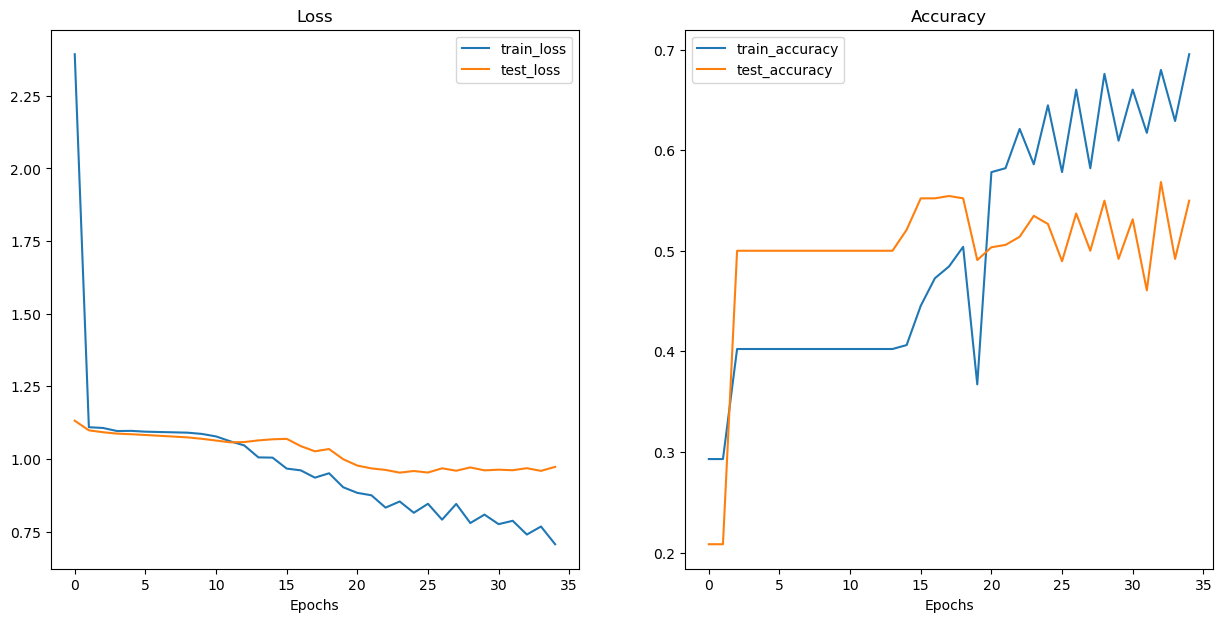

In [614]:
plot_loss_curves(model_0_results)

In [615]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

In [645]:
custom_image_path = Path('data/') / "001.jpg"
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

In [646]:

custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 1125, 1500])
New shape: torch.Size([3, 64, 64])


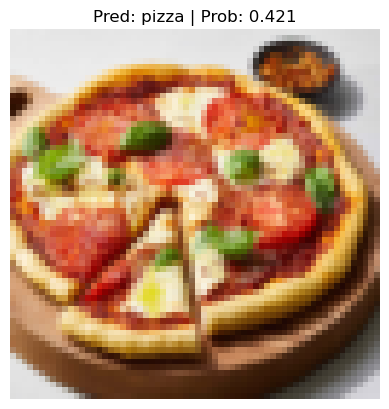

In [647]:
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names, device=device, transform=custom_image_transform)

In [649]:
PATH = Path('models')

MODEL_NAME = 'food_model_v0.pt'

SAVE_PATH = PATH / MODEL_NAME

torch.save(model.state_dict(), SAVE_PATH)